# Dropout 실습

이번 실습에서는 **Dropout** 이 Overfitting 완화에 어떻게 도움이 되는지 체감해봅니다.

- 작은 데이터셋과 복잡한 모델로 Overfitting 유도
- Dropout 유무 비교
- Validation Loss/Accuracy 곡선으로 비교

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. 데이터 준비 (작은 데이터셋 → Overfitting 유도)

In [10]:
# make_moons: 두 개의 반달 모양 클러스터를 생성하는 데이터셋
# n_samples=100: 총 100개의 샘플 (작은 데이터셋 → 과적합 유도)
# noise=0.25: 데이터에 노이즈 추가 (분류 난이도 증가)
# random_state=42: 재현 가능성을 위한 시드 설정
X, y = make_moons(n_samples=100, noise=0.25, random_state=42)

# 데이터를 훈련 세트(70%)와 테스트 세트(30%)로 분할
# 작은 데이터셋이므로 과적합이 쉽게 발생할 수 있음
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# StandardScaler: 데이터를 평균 0, 표준편차 1로 정규화
# 신경망 학습 시 수치 안정성과 수렴 속도를 향상시킴
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 후 변환
X_test = scaler.transform(X_test)         # 테스트 데이터는 학습된 스케일러로만 변환
# 주의: 테스트 데이터에는 fit_transform 사용하지 않음 (데이터 누수 방지)

## 2. Dropout 없는 모델과 Dropout 적용 모델 정의

In [13]:
def build_model_with_dropout():
    """
    Dropout을 적용한 모델
    
    Dropout이란?
    - 학습 시 무작위로 일부 뉴런을 비활성화(0으로 설정)하는 정규화 기법
    - 과적합을 방지하고 일반화 성능을 향상시킴
    
    Dropout(0.5)의 의미:
    - 각 뉴런이 50% 확률로 무작위로 비활성화됨
    - 학습 시마다 다른 뉴런 조합이 사용되어 모델이 특정 뉴런에 의존하지 않게 됨
    - 추론(예측) 시에는 모든 뉴런을 사용하되, 출력을 (1-dropout_rate)로 스케일링
    
    모델 구조:
    1. Dense(128): 첫 번째 은닉층 (input_shape=(2,))
    2. Dropout(0.5): 50% 뉴런 비활성화
    3. Dense(128): 두 번째 은닉층 (128개 뉴런)
    4. Dropout(0.5): 50% 뉴런 비활성화
    5. Dense(1, sigmoid): 이진 분류 출력층
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation="relu", input_shape=(2,)),  # 입력 정의 포함 첫 은닉층
        tf.keras.layers.Dropout(0.5),  # 50% 뉴런 무작위 비활성화
        tf.keras.layers.Dense(128, activation="relu"),  # 두 번째 은닉층
        tf.keras.layers.Dropout(0.5),  # 50% 뉴런 무작위 비활성화
        tf.keras.layers.Dense(1, activation="sigmoid")  # 이진 분류 출력 (0~1 확률)
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_model_without_dropout():
    """
    Dropout을 적용하지 않은 모델 (Baseline)
    
    작은 데이터셋(100개)과 복잡한 모델(128→128 뉴런)로 인해 과적합 발생 가능
    - 훈련 데이터에 너무 잘 맞춰져서 새로운 데이터에 대한 일반화 성능이 떨어짐
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation="relu", input_shape=(2,)),  # 입력 정의 포함 첫 은닉층
        tf.keras.layers.Dense(128, activation="relu"),  # 두 번째 은닉층
        tf.keras.layers.Dense(1, activation="sigmoid")  # 이진 분류 출력
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. 모델 학습 (Dropout 유무 비교)

In [14]:
# 두 모델 생성 (Dropout 유무 비교)
model_no_dropout = build_model_without_dropout()  # Dropout 없는 모델
model_with_dropout = build_model_with_dropout()   # Dropout 적용 모델

# Dropout 없는 모델 학습
# epochs=200: 많은 에포크로 과적합 발생 유도
# batch_size=16: 작은 배치 크기로 더 부드러운 학습
# verbose=0: 학습 과정 출력 없음 (히스토리만 저장)
history_no_dropout = model_no_dropout.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # 검증 데이터로 과적합 여부 확인
    epochs=200, batch_size=16, verbose=0
)
# 예상: 훈련 손실은 계속 감소하지만 검증 손실은 증가 (과적합)

# Dropout 적용 모델 학습
# Dropout이 과적합을 완화하여 일반화 성능 향상 기대
history_with_dropout = model_with_dropout.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200, batch_size=16, verbose=0
)
# 예상: 훈련 손실과 검증 손실이 모두 안정적으로 감소

## 4. 결과 시각화 (Loss & Accuracy)

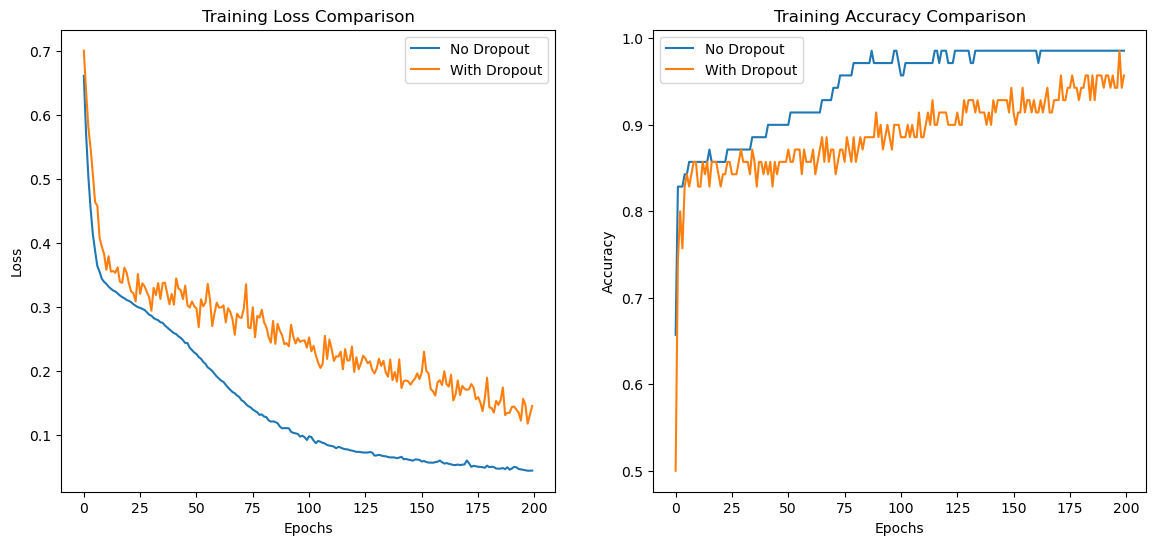

In [15]:
# 훈련 데이터에 대한 성능 비교 그래프
plt.figure(figsize=(14,6))

# 훈련 손실 비교
plt.subplot(1,2,1)
plt.plot(history_no_dropout.history["loss"], label="No Dropout")
plt.plot(history_with_dropout.history["loss"], label="With Dropout")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# 예상: Dropout 없는 모델이 더 낮은 훈련 손실을 보임 (훈련 데이터에 더 잘 맞춤)
# 하지만 이것이 과적합의 신호일 수 있음

# 훈련 정확도 비교
plt.subplot(1,2,2)
plt.plot(history_no_dropout.history["accuracy"], label="No Dropout")
plt.plot(history_with_dropout.history["accuracy"], label="With Dropout")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# 예상: Dropout 없는 모델이 더 높은 훈련 정확도를 보임
# 하지만 검증 정확도와 비교해야 실제 성능을 알 수 있음

plt.show()

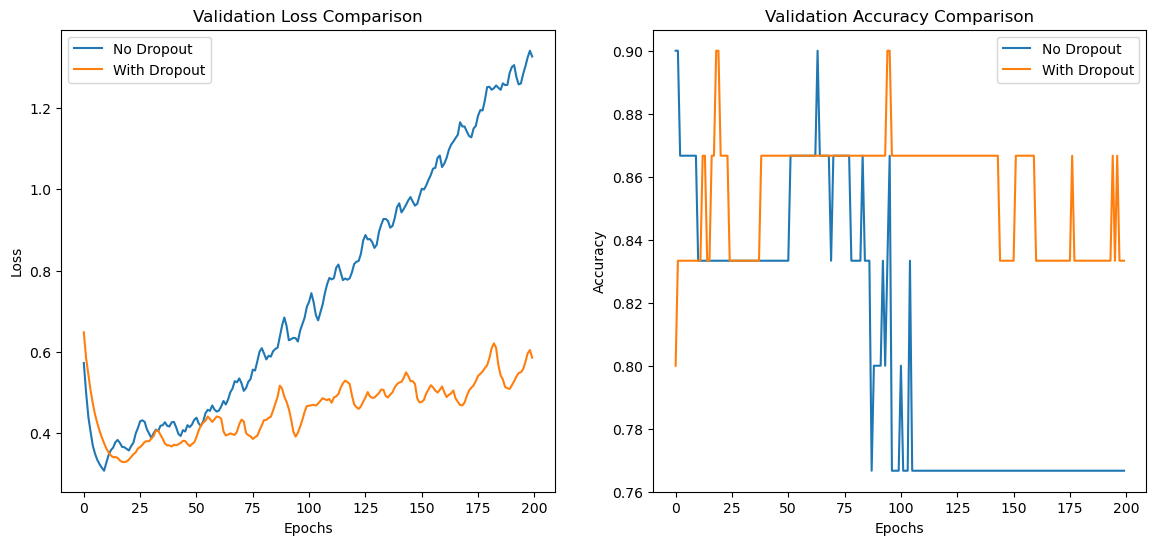

In [16]:
# 검증 데이터에 대한 성능 비교 그래프 (일반화 성능 확인)
plt.figure(figsize=(14,6))

# 검증 손실 비교 - 가장 중요한 지표!
plt.subplot(1,2,1)
plt.plot(history_no_dropout.history["val_loss"], label="No Dropout")
plt.plot(history_with_dropout.history["val_loss"], label="With Dropout")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# 예상 결과:
# - No Dropout: 초기에는 감소하다가 이후 증가 (과적합 발생)
# - With Dropout: 안정적으로 감소하거나 유지 (일반화 성능 향상)
# 검증 손실이 증가하면 과적합이 발생한 것임

# 검증 정확도 비교 - 실제 성능 확인
plt.subplot(1,2,2)
plt.plot(history_no_dropout.history["val_accuracy"], label="No Dropout")
plt.plot(history_with_dropout.history["val_accuracy"], label="With Dropout")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# 예상 결과:
# - No Dropout: 초기에는 증가하다가 이후 감소하거나 정체 (과적합)
# - With Dropout: 안정적으로 증가하고 유지 (일반화 성능 향상)
# Dropout이 적용된 모델이 더 높은 검증 정확도를 보일 것으로 예상됨

plt.show()

## 5. 결과 분석 및 도출점

### Dropout의 작동 원리

**학습 단계(Training):**
- 각 뉴런이 `dropout_rate` 확률로 무작위로 비활성화됨
- 예: Dropout(0.5)는 50%의 뉴런을 무작위로 0으로 설정
- 매 배치마다 다른 뉴런 조합이 사용됨
- 모델이 특정 뉴런에 의존하지 않고 다양한 경로를 학습하게 됨

**추론 단계(Inference):**
- 모든 뉴런을 사용하지만, 출력을 `(1 - dropout_rate)`로 스케일링
- 예: Dropout(0.5)인 경우 출력에 0.5를 곱함
- 이는 학습 시 사용 가능한 뉴런의 기대 비율을 반영

**왜 과적합을 방지하는가?**
1. **앙상블 효과**: 다양한 서브네트워크를 학습하는 것과 유사
2. **의존성 감소**: 특정 뉴런에 과도하게 의존하지 않음
3. **일반화 향상**: 더 견고한 특징 표현 학습

---

## 주요 도출점

### 1. 훈련 손실 vs 검증 손실 비교

**Dropout 없는 모델 (예상 결과):**
- **훈련 손실**: 지속적으로 감소 → 매우 낮은 수준 도달
- **검증 손실**: 초기 감소 후 증가 또는 정체 → 과적합 발생
- **차이**: 훈련 손실과 검증 손실 사이의 큰 격차 발생

**Dropout 있는 모델 (예상 결과):**
- **훈련 손실**: 완만하게 감소 (Dropout으로 인해 약간 높음)
- **검증 손실**: 안정적으로 감소하고 유지 → 일반화 성공
- **차이**: 훈련 손실과 검증 손실이 비슷하게 유지

**교훈:**
- 훈련 손실만 낮다고 좋은 모델이 아님
- **검증 손실이 가장 중요한 지표** → 실제 성능을 반영
- 두 손실 간의 격차가 크면 과적합 신호

---

### 2. 훈련 정확도 vs 검증 정확도 비교

**Dropout 없는 모델 (예상 결과):**
- **훈련 정확도**: 매우 높게 증가 (95% 이상)
- **검증 정확도**: 초기 증가 후 감소 또는 정체 (70-80%)
- **차이**: 약 15-20%p의 큰 격차

**Dropout 있는 모델 (예상 결과):**
- **훈련 정확도**: 완만하게 증가 (85-90%)
- **검증 정확도**: 안정적으로 증가 (85-90%)
- **차이**: 거의 차이가 없거나 매우 작음

**교훈:**
- 훈련 정확도가 높다고 해서 좋은 것은 아님
- **검증 정확도가 실제 성능을 나타냄**
- 두 정확도가 비슷하면 일반화가 잘 되고 있음

---

### 3. Dropout의 효과

**과적합 완화:**
- 작은 데이터셋(100개)과 복잡한 모델(128→128 뉴런)에서도 과적합 방지
- 검증 손실이 안정적으로 유지됨
- 일반화 성능 향상

**학습 속도:**
- Dropout은 학습을 약간 느리게 만들 수 있음 (훈련 손실이 더 천천히 감소)
- 하지만 더 견고한 모델을 학습하게 됨

**최종 성능:**
- Dropout 적용 모델이 더 높은 검증 정확도를 보일 가능성이 높음
- 실제 데이터에 대한 성능이 더 좋음

---

### 4. Dropout 사용 가이드

**언제 사용해야 하는가?**
- ✅ 작은 데이터셋
- ✅ 복잡한 모델 (깊거나 넓은 네트워크)
- ✅ 과적합이 발생하는 경우
- ✅ 일반화 성능을 향상시키고 싶을 때

**Dropout Rate 선택:**
- **일반적인 값**: 0.2 ~ 0.5
- **입력층**: 0.2 (낮게 설정)
- **은닉층**: 0.5 (표준)
- **출력층**: 보통 사용하지 않음

**주의사항:**
- 너무 높은 dropout rate (0.7 이상)는 학습을 방해할 수 있음
- 너무 낮은 dropout rate (0.1 이하)는 효과가 미미할 수 있음
- 데이터가 충분하고 모델이 단순하면 Dropout이 필요 없을 수 있음

---

### 5. 실무 적용 시 고려사항

**1. Early Stopping과 함께 사용:**
- Dropout + Early Stopping으로 과적합을 더 효과적으로 방지
- 검증 손실이 증가하기 시작하면 학습 중단

**2. 다른 정규화 기법과 비교:**
- **L1/L2 정규화**: 가중치 크기를 제한
- **Dropout**: 뉴런을 무작위로 비활성화
- **Batch Normalization**: 입력 분포를 정규화
- 여러 기법을 함께 사용할 수 있음

**3. 모델 복잡도 조절:**
- Dropout 없이도 모델 복잡도를 줄여서 과적합 방지 가능
- 하지만 Dropout을 사용하면 더 복잡한 모델도 안전하게 사용 가능

**4. 데이터 증강과 함께:**
- 이미지 데이터의 경우 Data Augmentation과 Dropout을 함께 사용
- 더 강력한 정규화 효과

---

### 6. 종합적인 결론

1. **Dropout은 과적합 방지에 효과적:**
   - 특히 작은 데이터셋과 복잡한 모델에서 유용
   - 검증 손실과 검증 정확도를 안정적으로 유지

2. **검증 지표가 중요:**
   - 훈련 손실/정확도만으로는 모델 성능을 판단할 수 없음
   - 검증 손실/정확도를 반드시 확인해야 함
   - 두 지표의 차이가 크면 과적합 신호

3. **Dropout의 트레이드오프:**
   - 학습 속도가 약간 느려질 수 있음
   - 하지만 더 견고하고 일반화된 모델을 학습
   - 최종 성능이 향상됨

4. **실무 권장사항:**
   - 복잡한 모델에서는 기본적으로 Dropout 적용 고려
   - Dropout rate는 0.5를 기본값으로 시작
   - 검증 지표를 모니터링하여 조정
   - Early Stopping과 함께 사용하여 최적 성능 확보

5. **과적합의 신호:**
   - 검증 손실이 증가하기 시작
   - 검증 정확도가 정체되거나 감소
   - 훈련 손실과 검증 손실의 큰 격차
   - → 이 경우 Dropout 적용 또는 모델 복잡도 감소 필요
